# Feature Engineering, Model Selection & Tuning Project

## Context:

Concrete is the most important material in civil engineering. The concrete compressive
strength is a highly nonlinear function of age and ingredients. These ingredients include
cement, blast furnace slag, fly ash, water, superplasticizer, coarse aggregate, and fine
aggregate.

## Data Description:

The actual concrete compressive strength (MPa) for a given mixture under a
specific age (days) was determined from laboratory. Data is in raw form (not scaled).The
data has 8 quantitative input variables, and 1 quantitative output variable, and 1030
instances (observations).

## Attribute Information:

● Cement : measured in kg in a m3 mixture  
● Blast : measured in kg in a m3 mixture  
● Fly ash : measured in kg in a m3 mixture  
● Water : measured in kg in a m3 mixture  
● Superplasticizer : measured in kg in a m3 mixture  
● Coarse Aggregate : measured in kg in a m3 mixture  
● Fine Aggregate : measured in kg in a m3 mixture  
● Age : day (1~365)  
● Concrete compressive strength measured in MPa  

## Objective:

Modeling of strength of high performance concrete using Machine Learning

In [1]:
# Import necessary libraries

import pandas            as pd
import numpy             as np
import matplotlib.pyplot as plt
import seaborn           as sns
import warnings

warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
# Read csv file as dataframe

concrete_df = pd.read_csv('concrete.csv')
concrete_df.head()

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
0,141.3,212.0,0.0,203.5,0.0,971.8,748.5,28,29.89
1,168.9,42.2,124.3,158.3,10.8,1080.8,796.2,14,23.51
2,250.0,0.0,95.7,187.4,5.5,956.9,861.2,28,29.22
3,266.0,114.0,0.0,228.0,0.0,932.0,670.0,28,45.85
4,154.8,183.4,0.0,193.3,9.1,1047.4,696.7,28,18.29


In [3]:
# Check the shape, null values and data type of each attribute
concrete_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 9 columns):
cement          1030 non-null float64
slag            1030 non-null float64
ash             1030 non-null float64
water           1030 non-null float64
superplastic    1030 non-null float64
coarseagg       1030 non-null float64
fineagg         1030 non-null float64
age             1030 non-null int64
strength        1030 non-null float64
dtypes: float64(8), int64(1)
memory usage: 72.5 KB


#### There 1030 rows with 9 columns (all numeric) having no null values...

In [4]:
# Check the data distribution within the columns
concrete_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
cement,1030.0,281.167864,104.506364,102.00,192.375,272.900,350.000,540.0
slag,1030.0,73.895825,86.279342,0.00,0.000,22.000,142.950,359.4
ash,1030.0,54.188350,63.997004,0.00,0.000,0.000,118.300,200.1
water,1030.0,181.567282,21.354219,121.80,164.900,185.000,192.000,247.0
superplastic,1030.0,6.204660,5.973841,0.00,0.000,6.400,10.200,32.2
coarseagg,1030.0,972.918932,77.753954,801.00,932.000,968.000,1029.400,1145.0
fineagg,1030.0,773.580485,80.175980,594.00,730.950,779.500,824.000,992.6
age,1030.0,45.662136,63.169912,1.00,7.000,28.000,56.000,365.0
strength,1030.0,35.817961,16.705742,2.33,23.710,34.445,46.135,82.6


#### Let's check for outliers in each feature and their count

In [5]:
# Define function to calculate and print out the outlier count

def get_outlier_summary(data, cols, return_index=False):
    """
    Identifies the outliers in the data
    and returns the column-wise outlier indices
    
    Extended description of function.

    Parameters
    ----------
    data : pd.DataFrame
        The dataframe in which to find the outliers
    
    cols : list like iterable
        Columns across which to find the outliers
    
    return_index : Boolean, default=False
        If True, returns the combined set of indices having outliers in at least one column
    
    Returns
    ----------
    set or int
        Based on return_index, returns either 
        combined set of indices having outlier in at least one column or 
        outliers count
    """
    
    global_indices = set()
    q1 = data[cols].quantile(0.25)
    q3 = data[cols].quantile(0.75)
    iqr = q3 - q1
    min_val = q1 - 1.5*iqr
    max_val = q3 + 1.5*iqr
    
    for col in cols:
        outliers = data[(data[col] > max_val[col]) | (data[col] < min_val[col])][col]
        outlier_count = outliers.count()
        local_indices = outliers.index
        global_indices.update(local_indices)
        print(f"Outliers in {col} are {outlier_count}")
            
    return global_indices if return_index else len(global_indices)

# Get the outlier in continuous features
outliers = get_outlier_summary(concrete_df, [col for col in concrete_df.columns if col != 'strength'], return_index=True)
print(f"Total outliers: {len(outliers)}")

Outliers in cement are 0
Outliers in slag are 2
Outliers in ash are 0
Outliers in water are 9
Outliers in superplastic are 10
Outliers in coarseagg are 0
Outliers in fineagg are 5
Outliers in age are 59
Total outliers: 85


In [6]:
# We will remove these outliers

concrete_df.drop(outliers, inplace=True)

## Univariate analysis

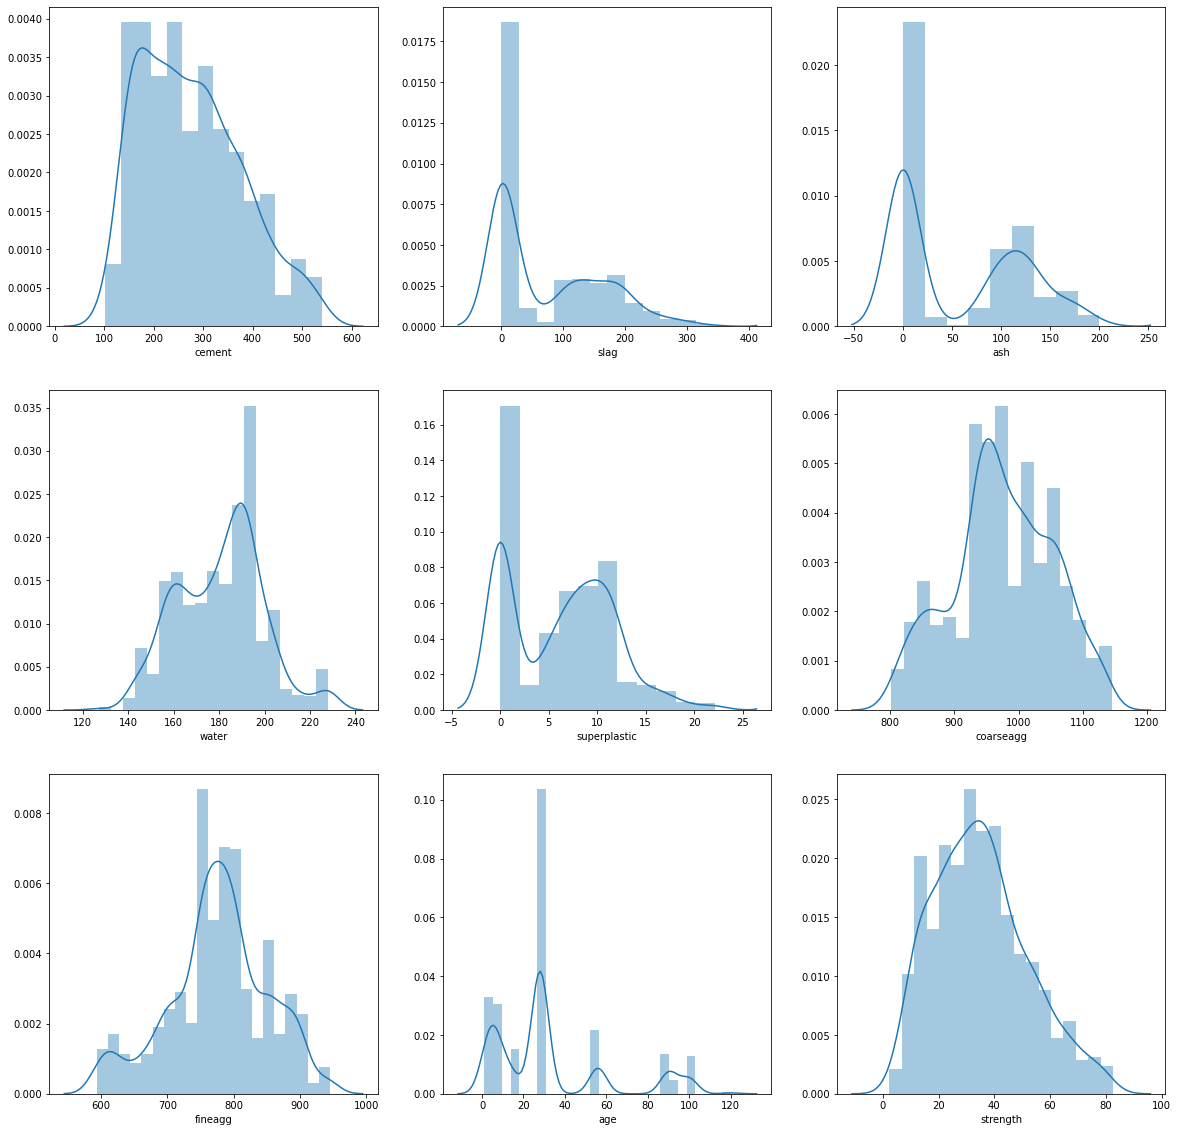

In [7]:
# Check distributions for continuous variables
continuous_vars = concrete_df.columns
f, axes = plt.subplots(3, 3, figsize=(20,20))

for i, var in enumerate(continuous_vars):
    sns.distplot(concrete_df[var], ax=axes.flatten()[i])

All the features have a **non-uniform and multi-modal distribution** but **slag, superplastic and age** have left skewed distributions.  
Multiple peaks also indicate at more than one gaussian present in the data, which can be later examined and converted into a feature

## Some Bivariate Analysis

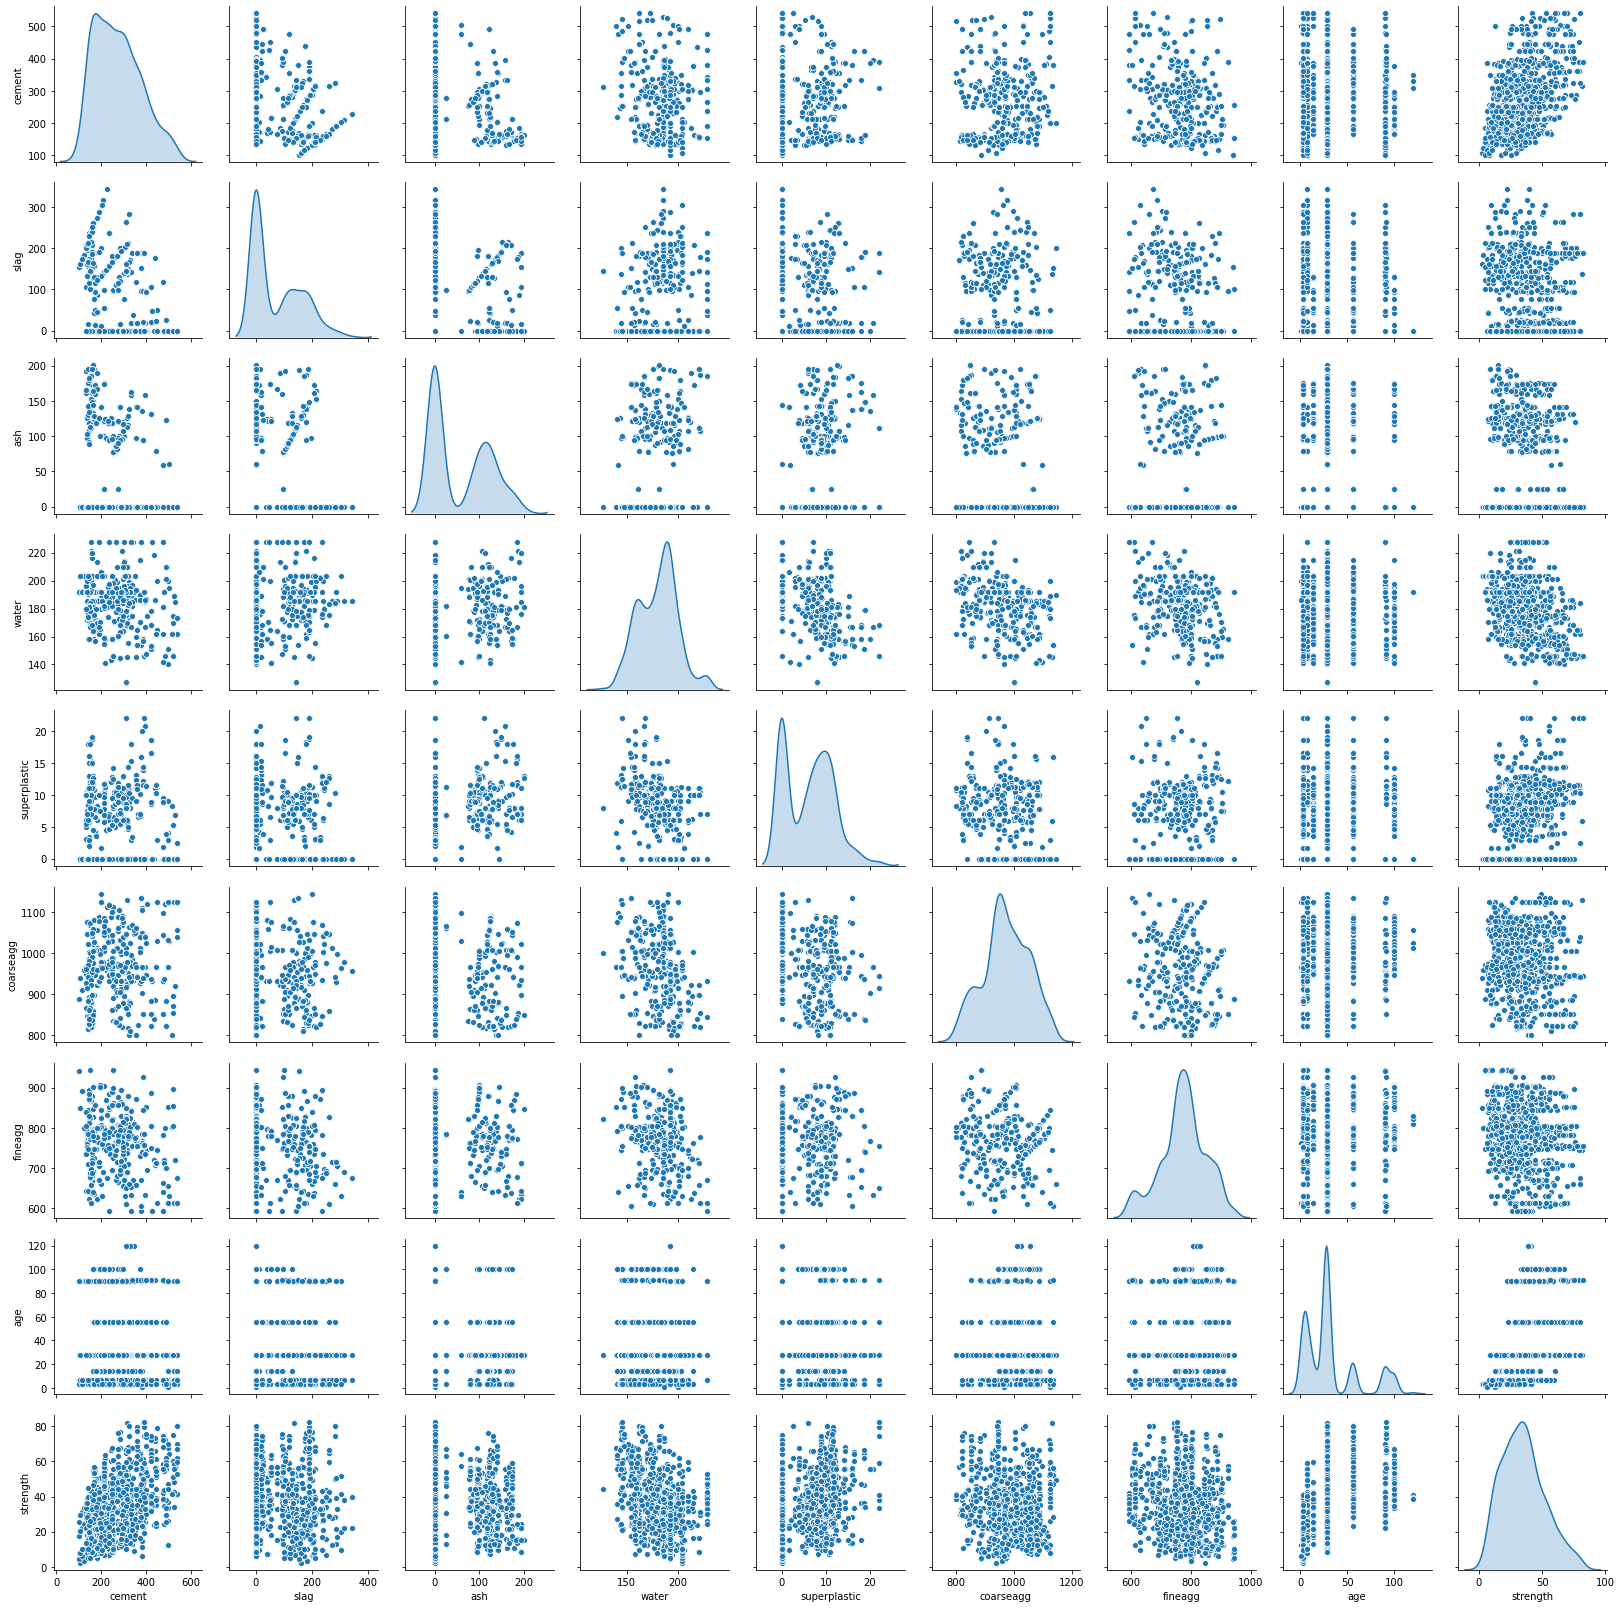

In [8]:
# We use seaborn pairplot to do the bivariate analysis for continuous features and target 

sns.pairplot(concrete_df, diag_kind='kde')

**superplastic** and **water** have very little negative correlation.  
**cement** and **strength** which is our target variable, have very little positive correlation.

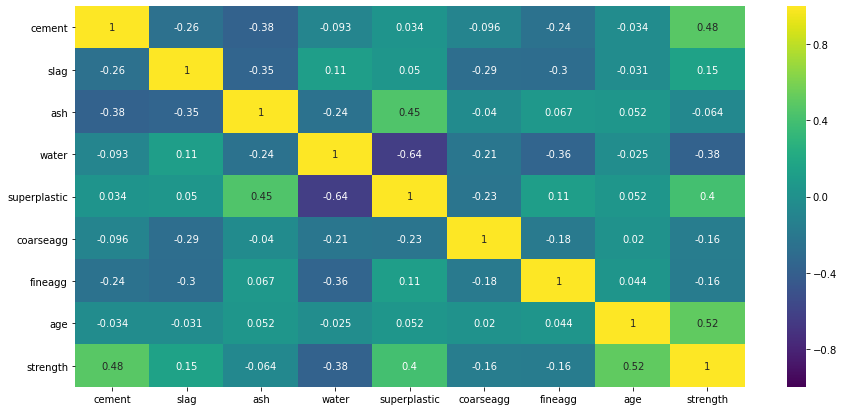

In [9]:
# Correlation among variables
plt.figure(figsize=[15,7])

sns.heatmap(concrete_df.corr(), cmap='viridis', vmin=-1, vmax=1, annot=True)

This shows that **cement, superplastic and age** have somewhat positive correlation with **strength**  
**superplastic and ash** have somewhat positive correlation while **superplastic and water** have somewhat negative correlation

### Before proceeding, we will split our data into train and test set so as to mimic realistic/production environments

In [10]:
from sklearn.model_selection import train_test_split

X = concrete_df.drop('strength', axis=1)
y = concrete_df['strength']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12)

### Set baseline performance

In [11]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
y_pred = lin_reg.predict(X_test)
r2_score(y_test, y_pred)

0.7878686114808894

#### The base model gives us a R-square score of 0.787. We will now employ feature engineering and hyperparameter tuning methods to better the score.

<br>

## Feature Engineering 

#### Since there is very little correlation present, we will try to create composite features using polynomial features with interaction
#### Also, as per the context of this problem, it has been stated that strength is a highly non-linear function

In [12]:
from sklearn.preprocessing import PolynomialFeatures

# Create 2nd degree features
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train, y_train)

# Save the poly object to be used later to transform the test data
model_resources = []
model_resources.append(poly)

In [13]:
X_train_poly.shape

(661, 45)

In [14]:
X_train_poly[0]

array([1.00000000e+00, 2.51400000e+02, 0.00000000e+00, 1.18300000e+02,
       1.92900000e+02, 5.80000000e+00, 1.04360000e+03, 7.54300000e+02,
       1.00000000e+02, 6.32019600e+04, 0.00000000e+00, 2.97406200e+04,
       4.84950600e+04, 1.45812000e+03, 2.62361040e+05, 1.89631020e+05,
       2.51400000e+04, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.39948900e+04, 2.28200700e+04, 6.86140000e+02, 1.23457880e+05,
       8.92336900e+04, 1.18300000e+04, 3.72104100e+04, 1.11882000e+03,
       2.01310440e+05, 1.45504470e+05, 1.92900000e+04, 3.36400000e+01,
       6.05288000e+03, 4.37494000e+03, 5.80000000e+02, 1.08910096e+06,
       7.87187480e+05, 1.04360000e+05, 5.68968490e+05, 7.54300000e+04,
       1.00000000e+04])

#### Now the number of features have increased from 8 to 45 but not all of these features are of importance, hence we will use regularization in the form of lasso regression to find the features of importance to us.  
#### But before that, we will explore the gaussians to see if we can find any clusters within the data and see the possibility of using it as a derived feature  

In [15]:
# We will use kmeans clustering to find the number of clusters
# But before that we need to scale the data

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train_scaled = pd.DataFrame(data=scaler.fit_transform(X_train_poly, y_train))

# Save the scaler object to be used later to transform the test data
model_resources.append(scaler)

Text(0.5, 1.0, 'Selecting k with the Elbow Method')

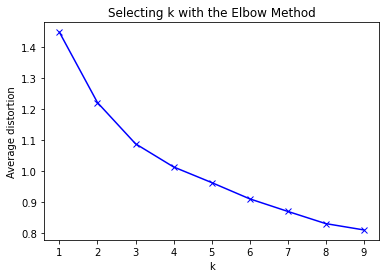

In [16]:
#Finding optimal no. of clusters
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

clusters=range(1,10)
meanDistortions=[]

for k in clusters:
    km_model=KMeans(n_clusters=k)
    km_model.fit(X_train_scaled)
    prediction=km_model.predict(X_train_scaled)
    meanDistortions.append(sum(np.min(cdist(X_train_scaled, km_model.cluster_centers_, 'euclidean'), axis=1)) / X_train_scaled.shape[0])


plt.plot(clusters, meanDistortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Average distortion')
plt.title('Selecting k with the Elbow Method')

**k=4** seems to be a reasonable choice.

In [17]:
# Setting K = 4
final_km_model=KMeans(4)
final_km_model.fit(X_train_scaled)
prediction=final_km_model.predict(X_train_scaled)

# Append the prediction 
X_train_scaled['cluster'] = [f"C{str(pred)}" for pred in prediction]

# Save the kmeans model object to be used later to transform the test data
model_resources.append(final_km_model)

In [18]:
# Get dummy columns for 'cluster'

X_train_scaled = pd.get_dummies(X_train_scaled, columns=['cluster'], drop_first=True)

### Finding important features using regularization techniques

In [19]:
# We will use Lasso regression to find most important features 
# and then will use these features only for the final model selection

from sklearn.linear_model import Lasso

lasso_model = Lasso()
lasso_model.fit(X_train_scaled, y_train)

# Print out coefficients 
print(lasso_model.coef_)

[ 0.          9.46762265  0.          0.         -0.          0.
 -0.         -0.         18.37693765  0.          0.          0.
  0.          6.86387495  0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
 -0.          0.          0.          0.          0.          0.
 -0.          0.         -0.         -1.03817547  0.          0.
  0.          0.          0.         -0.         -0.          0.
 -0.          0.          0.         -0.         -0.          7.17153473]


We note that most of the columns have been deemed not important for prediction by Lasso model  
We will capture these **5** important columns and work with these...

In [20]:
# Capture the important columns

col_indices = [list(lasso_model.coef_).index(coeff) for coeff in lasso_model.coef_ if coeff != 0.0]
important_cols = X_train_scaled.columns[col_indices]

# Save these columns to be later picked from test set
model_resources.append(important_cols)

print(important_cols)

Index([1, 8, 13, 33, 'cluster_C3'], dtype='object')


#### We note that one of the cluster column has been deemed important which was generated using kmeans clustering !!!

<br>

## Model Building and Tuning

We will use the following Regression algorithms and chose the one with best performance:

**1. Linear Regression**  
**2. Lasso Regression**  
**3. SVM Regressor**  
**4. KNN Regressor**  
**5. Random Forest Regressor**  
**6. XGBoost Regressor**  

In [21]:
# We create a generic grid search function which can be used for multiple ML models/algorithms
# It uses k-fold CV

import copy
from sklearn.model_selection import GridSearchCV, KFold

def get_best_model(X, y, estimator_specs):
    """
    Finds the best model among the estimators among all possible ones
    as defined in param_grid and returns the best estimator.

    Extended description of function.

    Parameters
    ----------
    X : {array-like, sparse matrix} of shape (n_samples, n_features)
        Samples vector, where n_samples is the number of samples and
        n_features is the number of features.
    
    y : array-like of shape (n_samples,)
        Target vector relative to X.
    
    estimator_specs : list of dictionaries
        List of dictionaries where each dictionary specifies the details of a single estimator object.
        The dictionary has following keys and values:
        
            estimator  : estimator object
                An estimator object (classifier instance)
                
            params : dict or list of dictionaries
                Dictionary with parameters names (string) as keys and lists of parameter settings to try as values,
                or a list of such dictionaries, in which case the grids spanned by each dictionary in the list are explored.
                This enables searching over any sequence of parameter settings.
                
            scorer : scoring function or None
                A custom scoring function. This goes as a value to 'scoring' argument in GridSearchCV.
                If None, then estimator's score function is used.
    
    Returns
    -------
    List of estimator objects(as dictionaries)
        List of dictionaries of best estimator object (which has best score) along with their scores and results.

    """
    
    kfold = KFold(n_splits=10, shuffle=True, random_state=42)
    
    results = list()
    for estimator in estimator_specs:
        best_estimator = dict()
        gs_object = GridSearchCV(estimator['estimator'],
                                param_grid=estimator['params'],
                                scoring=estimator['scorer'],
                                cv=kfold,
                                verbose=2)
        gs_object.fit(X, y)
        best_estimator['estimator'] = gs_object.best_estimator_
        best_estimator['score'] = gs_object.best_score_
        best_estimator['results'] = pd.DataFrame(gs_object.cv_results_).drop('params', axis=1)
        results.append(copy.deepcopy(best_estimator))
    
    return results

In [22]:
# Since we have fixed the number of features, we will use the r2_score as our custom scorer
from sklearn.metrics import make_scorer, r2_score
custom_scorer = make_scorer(r2_score)

In [23]:
# We define the parameter grids for each of the models
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# Linear Regression (Not much tuning possible)
linear_params = {'normalize': [True, False]}

# Lasso Regression
lasso_params = {'alpha': [0.01, 0.05, 0.1, 1.0, 10, 100]}

# SVR
svr_params = {'C': [0.01, 0.1, 1, 10],
              'gamma': [0.01, 0.1, 1, 10],
              'kernel': ['poly', 'rbf']}

# KNN Regressor
knn_params = {'n_neighbors': [5, 11, 19, 25, 33, 35, 39, 43],
              'metric': ['manhattan', 'euclidean'],
              'algorithm': ['auto', 'kd_tree']}

# Random forest Regressor
rf_params = {'n_estimators': [50, 100, 150, 200, 300],
             'max_features': ['log2', 'auto'],
             'max_depth': [3, 5, 7]}

# XG boost Regressor
xgb_params = {'n_estimators': [150, 200, 250, 300, 500],
              'max_depth': [3, 5, 7, 9],
              'learning_rate': [0.05, 0.1, 0.3, 0.5]}


# Define estimator specs for each model to be passed into get_best_model()
estimator_specs = [
    {
        # Linear Regression
        'estimator': LinearRegression(),
        'params'   : linear_params,
        'scorer'   : custom_scorer
    },
    {
        # Lasso Regression
        'estimator': Lasso(random_state=42),
        'params'   : lasso_params,
        'scorer'   : custom_scorer
    },
    {
        # SVR
        'estimator': SVR(),
        'params'   : svr_params,
        'scorer'   : custom_scorer        
    },
    {
        # KNN Regressor
        'estimator': KNeighborsRegressor(),
        'params'   : knn_params,
        'scorer'   : custom_scorer        
    },
    {
        # RF Regressor
        'estimator': RandomForestRegressor(random_state=42),
        'params'   : rf_params,
        'scorer'   : custom_scorer        
    },
    {
        # XGB Regressor
        'estimator': XGBRegressor(random_state=42),
        'params'   : xgb_params,
        'scorer'   : custom_scorer        
    }
]

# Apply the important columns filter
X_train_final = X_train_scaled[important_cols]
results = get_best_model(X_train_final, y_train, estimator_specs)

Fitting 10 folds for each of 2 candidates, totalling 20 fits
[CV] normalize=True ..................................................
[CV] ................................... normalize=True, total=   0.0s
[CV] normalize=True ..................................................
[CV] ................................... normalize=True, total=   0.0s
[CV] normalize=True ..................................................
[CV] ................................... normalize=True, total=   0.0s
[CV] normalize=True ..................................................
[CV] ................................... normalize=True, total=   0.0s
[CV] normalize=True ..................................................
[CV] ................................... normalize=True, total=   0.0s
[CV] normalize=True ..................................................
[CV] ................................... normalize=True, total=   0.0s
[CV] normalize=True ..................................................
[CV] ...........

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s



[CV] ....................................... alpha=0.05, total=   0.0s
[CV] alpha=0.05 ......................................................
[CV] ....................................... alpha=0.05, total=   0.0s
[CV] alpha=0.05 ......................................................
[CV] ....................................... alpha=0.05, total=   0.0s
[CV] alpha=0.05 ......................................................
[CV] ....................................... alpha=0.05, total=   0.0s
[CV] alpha=0.05 ......................................................
[CV] ....................................... alpha=0.05, total=   0.0s
[CV] alpha=0.05 ......................................................
[CV] ....................................... alpha=0.05, total=   0.0s
[CV] alpha=0.05 ......................................................
[CV] ....................................... alpha=0.05, total=   0.0s
[CV] alpha=0.05 ......................................................
[CV] 

[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s



[CV] C=0.01, gamma=0.01, kernel=poly .................................
[CV] .................. C=0.01, gamma=0.01, kernel=poly, total=   0.0s
[CV] C=0.01, gamma=0.01, kernel=poly .................................
[CV] .................. C=0.01, gamma=0.01, kernel=poly, total=   0.0s
[CV] C=0.01, gamma=0.01, kernel=poly .................................
[CV] .................. C=0.01, gamma=0.01, kernel=poly, total=   0.0s
[CV] C=0.01, gamma=0.01, kernel=poly .................................
[CV] .................. C=0.01, gamma=0.01, kernel=poly, total=   0.0s
[CV] C=0.01, gamma=0.01, kernel=poly .................................
[CV] .................. C=0.01, gamma=0.01, kernel=poly, total=   0.0s
[CV] C=0.01, gamma=0.01, kernel=rbf ..................................
[CV] ................... C=0.01, gamma=0.01, kernel=rbf, total=   0.0s
[CV] C=0.01, gamma=0.01, kernel=rbf ..................................
[CV] ................... C=0.01, gamma=0.01, kernel=rbf, total=   0.0s
[CV] 

[CV] .................... C=0.01, gamma=10, kernel=poly, total=   0.0s
[CV] C=0.01, gamma=10, kernel=rbf ....................................
[CV] ..................... C=0.01, gamma=10, kernel=rbf, total=   0.0s
[CV] C=0.01, gamma=10, kernel=rbf ....................................
[CV] ..................... C=0.01, gamma=10, kernel=rbf, total=   0.0s
[CV] C=0.01, gamma=10, kernel=rbf ....................................
[CV] ..................... C=0.01, gamma=10, kernel=rbf, total=   0.0s
[CV] C=0.01, gamma=10, kernel=rbf ....................................
[CV] ..................... C=0.01, gamma=10, kernel=rbf, total=   0.0s
[CV] C=0.01, gamma=10, kernel=rbf ....................................
[CV] ..................... C=0.01, gamma=10, kernel=rbf, total=   0.0s
[CV] C=0.01, gamma=10, kernel=rbf ....................................
[CV] ..................... C=0.01, gamma=10, kernel=rbf, total=   0.0s
[CV] C=0.01, gamma=10, kernel=rbf ....................................
[CV] .

[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .

[CV] ....................... C=1, gamma=0.1, kernel=rbf, total=   0.0s
[CV] C=1, gamma=0.1, kernel=rbf ......................................
[CV] ....................... C=1, gamma=0.1, kernel=rbf, total=   0.0s
[CV] C=1, gamma=0.1, kernel=rbf ......................................
[CV] ....................... C=1, gamma=0.1, kernel=rbf, total=   0.0s
[CV] C=1, gamma=0.1, kernel=rbf ......................................
[CV] ....................... C=1, gamma=0.1, kernel=rbf, total=   0.0s
[CV] C=1, gamma=0.1, kernel=rbf ......................................
[CV] ....................... C=1, gamma=0.1, kernel=rbf, total=   0.0s
[CV] C=1, gamma=1, kernel=poly .......................................
[CV] ........................ C=1, gamma=1, kernel=poly, total=   0.0s
[CV] C=1, gamma=1, kernel=poly .......................................
[CV] ........................ C=1, gamma=1, kernel=poly, total=   0.0s
[CV] C=1, gamma=1, kernel=poly .......................................
[CV] .

[CV] ..................... C=10, gamma=0.01, kernel=rbf, total=   0.0s
[CV] C=10, gamma=0.01, kernel=rbf ....................................
[CV] ..................... C=10, gamma=0.01, kernel=rbf, total=   0.0s
[CV] C=10, gamma=0.1, kernel=poly ....................................
[CV] ..................... C=10, gamma=0.1, kernel=poly, total=   0.0s
[CV] C=10, gamma=0.1, kernel=poly ....................................
[CV] ..................... C=10, gamma=0.1, kernel=poly, total=   0.0s
[CV] C=10, gamma=0.1, kernel=poly ....................................
[CV] ..................... C=10, gamma=0.1, kernel=poly, total=   0.0s
[CV] C=10, gamma=0.1, kernel=poly ....................................
[CV] ..................... C=10, gamma=0.1, kernel=poly, total=   0.0s
[CV] C=10, gamma=0.1, kernel=poly ....................................
[CV] ..................... C=10, gamma=0.1, kernel=poly, total=   0.0s
[CV] C=10, gamma=0.1, kernel=poly ....................................
[CV] .

[Parallel(n_jobs=1)]: Done 320 out of 320 | elapsed:   38.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] .. algorithm=auto, metric=manhattan, n_neighbors=5, total=   0.0s
[CV] algorithm=auto, metric=manhattan, n_neighbors=5 .................
[CV] .. algorithm=auto, metric=manhattan, n_neighbors=5, total=   0.0s
[CV] algorithm=auto, metric=manhattan, n_neighbors=5 .................
[CV] .. algorithm=auto, metric=manhattan, n_neighbors=5, total=   0.0s
[CV] algorithm=auto, metric=manhattan, n_neighbors=5 .................
[CV] .. algorithm=auto, metric=manhattan, n_neighbors=5, total=   0.0s
[CV] algorithm=auto, metric=manhattan, n_neighbors=5 .................
[CV] .. algorithm=auto, metric=manhattan, n_neighbors=5, total=   0.0s
[CV] algorithm=auto, metric=manhattan, n_neighbors=5 .................
[CV] .. algorithm=auto, metric=manhattan, n_neighbors=5, total=   0.0s
[CV] algorithm=auto, metric=manhattan, n_neighbors=5 .................
[CV] .. algorithm=auto, metric=manhattan, n_neighbors=5, total=   0.0s
[CV] algorithm=auto, metric=manhattan, n_neighbors=11 ................
[CV] .

[CV] .. algorithm=auto, metric=euclidean, n_neighbors=5, total=   0.0s
[CV] algorithm=auto, metric=euclidean, n_neighbors=5 .................
[CV] .. algorithm=auto, metric=euclidean, n_neighbors=5, total=   0.0s
[CV] algorithm=auto, metric=euclidean, n_neighbors=5 .................
[CV] .. algorithm=auto, metric=euclidean, n_neighbors=5, total=   0.0s
[CV] algorithm=auto, metric=euclidean, n_neighbors=5 .................
[CV] .. algorithm=auto, metric=euclidean, n_neighbors=5, total=   0.0s
[CV] algorithm=auto, metric=euclidean, n_neighbors=5 .................
[CV] .. algorithm=auto, metric=euclidean, n_neighbors=5, total=   0.0s
[CV] algorithm=auto, metric=euclidean, n_neighbors=5 .................
[CV] .. algorithm=auto, metric=euclidean, n_neighbors=5, total=   0.0s
[CV] algorithm=auto, metric=euclidean, n_neighbors=5 .................
[CV] .. algorithm=auto, metric=euclidean, n_neighbors=5, total=   0.0s
[CV] algorithm=auto, metric=euclidean, n_neighbors=11 ................
[CV] .

[CV]  algorithm=kd_tree, metric=manhattan, n_neighbors=5, total=   0.0s
[CV] algorithm=kd_tree, metric=manhattan, n_neighbors=5 ..............
[CV]  algorithm=kd_tree, metric=manhattan, n_neighbors=5, total=   0.0s
[CV] algorithm=kd_tree, metric=manhattan, n_neighbors=5 ..............
[CV]  algorithm=kd_tree, metric=manhattan, n_neighbors=5, total=   0.0s
[CV] algorithm=kd_tree, metric=manhattan, n_neighbors=5 ..............
[CV]  algorithm=kd_tree, metric=manhattan, n_neighbors=5, total=   0.0s
[CV] algorithm=kd_tree, metric=manhattan, n_neighbors=5 ..............
[CV]  algorithm=kd_tree, metric=manhattan, n_neighbors=5, total=   0.0s
[CV] algorithm=kd_tree, metric=manhattan, n_neighbors=5 ..............
[CV]  algorithm=kd_tree, metric=manhattan, n_neighbors=5, total=   0.0s
[CV] algorithm=kd_tree, metric=manhattan, n_neighbors=11 .............
[CV]  algorithm=kd_tree, metric=manhattan, n_neighbors=11, total=   0.0s
[CV] algorithm=kd_tree, metric=manhattan, n_neighbors=11 ............

[CV]  algorithm=kd_tree, metric=euclidean, n_neighbors=5, total=   0.0s
[CV] algorithm=kd_tree, metric=euclidean, n_neighbors=5 ..............
[CV]  algorithm=kd_tree, metric=euclidean, n_neighbors=5, total=   0.0s
[CV] algorithm=kd_tree, metric=euclidean, n_neighbors=5 ..............
[CV]  algorithm=kd_tree, metric=euclidean, n_neighbors=5, total=   0.0s
[CV] algorithm=kd_tree, metric=euclidean, n_neighbors=5 ..............
[CV]  algorithm=kd_tree, metric=euclidean, n_neighbors=5, total=   0.0s
[CV] algorithm=kd_tree, metric=euclidean, n_neighbors=5 ..............
[CV]  algorithm=kd_tree, metric=euclidean, n_neighbors=5, total=   0.0s
[CV] algorithm=kd_tree, metric=euclidean, n_neighbors=5 ..............
[CV]  algorithm=kd_tree, metric=euclidean, n_neighbors=5, total=   0.0s
[CV] algorithm=kd_tree, metric=euclidean, n_neighbors=11 .............
[CV]  algorithm=kd_tree, metric=euclidean, n_neighbors=11, total=   0.0s
[CV] algorithm=kd_tree, metric=euclidean, n_neighbors=11 ............

[Parallel(n_jobs=1)]: Done 320 out of 320 | elapsed:    2.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] .. max_depth=3, max_features=log2, n_estimators=50, total=   0.1s
[CV] max_depth=3, max_features=log2, n_estimators=50 .................
[CV] .. max_depth=3, max_features=log2, n_estimators=50, total=   0.1s
[CV] max_depth=3, max_features=log2, n_estimators=50 .................
[CV] .. max_depth=3, max_features=log2, n_estimators=50, total=   0.1s
[CV] max_depth=3, max_features=log2, n_estimators=50 .................
[CV] .. max_depth=3, max_features=log2, n_estimators=50, total=   0.1s
[CV] max_depth=3, max_features=log2, n_estimators=50 .................
[CV] .. max_depth=3, max_features=log2, n_estimators=50, total=   0.1s
[CV] max_depth=3, max_features=log2, n_estimators=50 .................
[CV] .. max_depth=3, max_features=log2, n_estimators=50, total=   0.1s
[CV] max_depth=3, max_features=log2, n_estimators=50 .................
[CV] .. max_depth=3, max_features=log2, n_estimators=50, total=   0.1s
[CV] max_depth=3, max_features=log2, n_estimators=50 .................
[CV] .

[CV] .. max_depth=3, max_features=auto, n_estimators=50, total=   0.1s
[CV] max_depth=3, max_features=auto, n_estimators=50 .................
[CV] .. max_depth=3, max_features=auto, n_estimators=50, total=   0.1s
[CV] max_depth=3, max_features=auto, n_estimators=100 ................
[CV] . max_depth=3, max_features=auto, n_estimators=100, total=   0.2s
[CV] max_depth=3, max_features=auto, n_estimators=100 ................
[CV] . max_depth=3, max_features=auto, n_estimators=100, total=   0.2s
[CV] max_depth=3, max_features=auto, n_estimators=100 ................
[CV] . max_depth=3, max_features=auto, n_estimators=100, total=   0.2s
[CV] max_depth=3, max_features=auto, n_estimators=100 ................
[CV] . max_depth=3, max_features=auto, n_estimators=100, total=   0.2s
[CV] max_depth=3, max_features=auto, n_estimators=100 ................
[CV] . max_depth=3, max_features=auto, n_estimators=100, total=   0.2s
[CV] max_depth=3, max_features=auto, n_estimators=100 ................
[CV] .

[CV] . max_depth=5, max_features=log2, n_estimators=100, total=   0.2s
[CV] max_depth=5, max_features=log2, n_estimators=100 ................
[CV] . max_depth=5, max_features=log2, n_estimators=100, total=   0.2s
[CV] max_depth=5, max_features=log2, n_estimators=100 ................
[CV] . max_depth=5, max_features=log2, n_estimators=100, total=   0.2s
[CV] max_depth=5, max_features=log2, n_estimators=100 ................
[CV] . max_depth=5, max_features=log2, n_estimators=100, total=   0.2s
[CV] max_depth=5, max_features=log2, n_estimators=150 ................
[CV] . max_depth=5, max_features=log2, n_estimators=150, total=   0.3s
[CV] max_depth=5, max_features=log2, n_estimators=150 ................
[CV] . max_depth=5, max_features=log2, n_estimators=150, total=   0.3s
[CV] max_depth=5, max_features=log2, n_estimators=150 ................
[CV] . max_depth=5, max_features=log2, n_estimators=150, total=   0.3s
[CV] max_depth=5, max_features=log2, n_estimators=150 ................
[CV] .

[CV] . max_depth=5, max_features=auto, n_estimators=150, total=   0.3s
[CV] max_depth=5, max_features=auto, n_estimators=150 ................
[CV] . max_depth=5, max_features=auto, n_estimators=150, total=   0.3s
[CV] max_depth=5, max_features=auto, n_estimators=150 ................
[CV] . max_depth=5, max_features=auto, n_estimators=150, total=   0.3s
[CV] max_depth=5, max_features=auto, n_estimators=150 ................
[CV] . max_depth=5, max_features=auto, n_estimators=150, total=   0.3s
[CV] max_depth=5, max_features=auto, n_estimators=150 ................
[CV] . max_depth=5, max_features=auto, n_estimators=150, total=   0.3s
[CV] max_depth=5, max_features=auto, n_estimators=150 ................
[CV] . max_depth=5, max_features=auto, n_estimators=150, total=   0.3s
[CV] max_depth=5, max_features=auto, n_estimators=200 ................
[CV] . max_depth=5, max_features=auto, n_estimators=200, total=   0.4s
[CV] max_depth=5, max_features=auto, n_estimators=200 ................
[CV] .

[CV] . max_depth=7, max_features=log2, n_estimators=200, total=   0.4s
[CV] max_depth=7, max_features=log2, n_estimators=200 ................
[CV] . max_depth=7, max_features=log2, n_estimators=200, total=   0.4s
[CV] max_depth=7, max_features=log2, n_estimators=200 ................
[CV] . max_depth=7, max_features=log2, n_estimators=200, total=   0.4s
[CV] max_depth=7, max_features=log2, n_estimators=200 ................
[CV] . max_depth=7, max_features=log2, n_estimators=200, total=   0.4s
[CV] max_depth=7, max_features=log2, n_estimators=200 ................
[CV] . max_depth=7, max_features=log2, n_estimators=200, total=   0.4s
[CV] max_depth=7, max_features=log2, n_estimators=200 ................
[CV] . max_depth=7, max_features=log2, n_estimators=200, total=   0.4s
[CV] max_depth=7, max_features=log2, n_estimators=200 ................
[CV] . max_depth=7, max_features=log2, n_estimators=200, total=   0.4s
[CV] max_depth=7, max_features=log2, n_estimators=200 ................
[CV] .

[CV] . max_depth=7, max_features=auto, n_estimators=300, total=   0.7s
[CV] max_depth=7, max_features=auto, n_estimators=300 ................
[CV] . max_depth=7, max_features=auto, n_estimators=300, total=   0.7s
[CV] max_depth=7, max_features=auto, n_estimators=300 ................
[CV] . max_depth=7, max_features=auto, n_estimators=300, total=   0.7s
[CV] max_depth=7, max_features=auto, n_estimators=300 ................
[CV] . max_depth=7, max_features=auto, n_estimators=300, total=   0.7s
[CV] max_depth=7, max_features=auto, n_estimators=300 ................
[CV] . max_depth=7, max_features=auto, n_estimators=300, total=   0.7s
[CV] max_depth=7, max_features=auto, n_estimators=300 ................
[CV] . max_depth=7, max_features=auto, n_estimators=300, total=   0.7s
[CV] max_depth=7, max_features=auto, n_estimators=300 ................
[CV] . max_depth=7, max_features=auto, n_estimators=300, total=   0.7s
[CV] max_depth=7, max_features=auto, n_estimators=300 ................
[CV] .

[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:  1.5min finished


Fitting 10 folds for each of 80 candidates, totalling 800 fits
[CV] learning_rate=0.05, max_depth=3, n_estimators=150 ...............
[CV]  learning_rate=0.05, max_depth=3, n_estimators=150, total=   0.1s
[CV] learning_rate=0.05, max_depth=3, n_estimators=150 ...............
[CV]  learning_rate=0.05, max_depth=3, n_estimators=150, total=   0.1s
[CV] learning_rate=0.05, max_depth=3, n_estimators=150 ...............
[CV]  learning_rate=0.05, max_depth=3, n_estimators=150, total=   0.1s

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s



[CV] learning_rate=0.05, max_depth=3, n_estimators=150 ...............
[CV]  learning_rate=0.05, max_depth=3, n_estimators=150, total=   0.1s
[CV] learning_rate=0.05, max_depth=3, n_estimators=150 ...............
[CV]  learning_rate=0.05, max_depth=3, n_estimators=150, total=   0.1s
[CV] learning_rate=0.05, max_depth=3, n_estimators=150 ...............
[CV]  learning_rate=0.05, max_depth=3, n_estimators=150, total=   0.1s
[CV] learning_rate=0.05, max_depth=3, n_estimators=150 ...............
[CV]  learning_rate=0.05, max_depth=3, n_estimators=150, total=   0.1s
[CV] learning_rate=0.05, max_depth=3, n_estimators=150 ...............
[CV]  learning_rate=0.05, max_depth=3, n_estimators=150, total=   0.1s
[CV] learning_rate=0.05, max_depth=3, n_estimators=150 ...............
[CV]  learning_rate=0.05, max_depth=3, n_estimators=150, total=   0.1s
[CV] learning_rate=0.05, max_depth=3, n_estimators=150 ...............
[CV]  learning_rate=0.05, max_depth=3, n_estimators=150, total=   0.1s
[CV] 

[CV] learning_rate=0.05, max_depth=5, n_estimators=200 ...............
[CV]  learning_rate=0.05, max_depth=5, n_estimators=200, total=   0.1s
[CV] learning_rate=0.05, max_depth=5, n_estimators=200 ...............
[CV]  learning_rate=0.05, max_depth=5, n_estimators=200, total=   0.1s
[CV] learning_rate=0.05, max_depth=5, n_estimators=200 ...............
[CV]  learning_rate=0.05, max_depth=5, n_estimators=200, total=   0.1s
[CV] learning_rate=0.05, max_depth=5, n_estimators=200 ...............
[CV]  learning_rate=0.05, max_depth=5, n_estimators=200, total=   0.1s
[CV] learning_rate=0.05, max_depth=5, n_estimators=200 ...............
[CV]  learning_rate=0.05, max_depth=5, n_estimators=200, total=   0.1s
[CV] learning_rate=0.05, max_depth=5, n_estimators=200 ...............
[CV]  learning_rate=0.05, max_depth=5, n_estimators=200, total=   0.1s
[CV] learning_rate=0.05, max_depth=5, n_estimators=200 ...............
[CV]  learning_rate=0.05, max_depth=5, n_estimators=200, total=   0.1s
[CV] l

[CV]  learning_rate=0.05, max_depth=7, n_estimators=200, total=   0.1s
[CV] learning_rate=0.05, max_depth=7, n_estimators=250 ...............
[CV]  learning_rate=0.05, max_depth=7, n_estimators=250, total=   0.1s
[CV] learning_rate=0.05, max_depth=7, n_estimators=250 ...............
[CV]  learning_rate=0.05, max_depth=7, n_estimators=250, total=   0.2s
[CV] learning_rate=0.05, max_depth=7, n_estimators=250 ...............
[CV]  learning_rate=0.05, max_depth=7, n_estimators=250, total=   0.2s
[CV] learning_rate=0.05, max_depth=7, n_estimators=250 ...............
[CV]  learning_rate=0.05, max_depth=7, n_estimators=250, total=   0.2s
[CV] learning_rate=0.05, max_depth=7, n_estimators=250 ...............
[CV]  learning_rate=0.05, max_depth=7, n_estimators=250, total=   0.2s
[CV] learning_rate=0.05, max_depth=7, n_estimators=250 ...............
[CV]  learning_rate=0.05, max_depth=7, n_estimators=250, total=   0.1s
[CV] learning_rate=0.05, max_depth=7, n_estimators=250 ...............
[CV]  

[CV]  learning_rate=0.05, max_depth=9, n_estimators=250, total=   0.2s
[CV] learning_rate=0.05, max_depth=9, n_estimators=250 ...............
[CV]  learning_rate=0.05, max_depth=9, n_estimators=250, total=   0.2s
[CV] learning_rate=0.05, max_depth=9, n_estimators=250 ...............
[CV]  learning_rate=0.05, max_depth=9, n_estimators=250, total=   0.2s
[CV] learning_rate=0.05, max_depth=9, n_estimators=300 ...............
[CV]  learning_rate=0.05, max_depth=9, n_estimators=300, total=   0.3s
[CV] learning_rate=0.05, max_depth=9, n_estimators=300 ...............
[CV]  learning_rate=0.05, max_depth=9, n_estimators=300, total=   0.3s
[CV] learning_rate=0.05, max_depth=9, n_estimators=300 ...............
[CV]  learning_rate=0.05, max_depth=9, n_estimators=300, total=   0.3s
[CV] learning_rate=0.05, max_depth=9, n_estimators=300 ...............
[CV]  learning_rate=0.05, max_depth=9, n_estimators=300, total=   0.2s
[CV] learning_rate=0.05, max_depth=9, n_estimators=300 ...............
[CV]  

[CV] . learning_rate=0.1, max_depth=3, n_estimators=300, total=   0.1s
[CV] learning_rate=0.1, max_depth=3, n_estimators=300 ................
[CV] . learning_rate=0.1, max_depth=3, n_estimators=300, total=   0.1s
[CV] learning_rate=0.1, max_depth=3, n_estimators=300 ................
[CV] . learning_rate=0.1, max_depth=3, n_estimators=300, total=   0.1s
[CV] learning_rate=0.1, max_depth=3, n_estimators=300 ................
[CV] . learning_rate=0.1, max_depth=3, n_estimators=300, total=   0.1s
[CV] learning_rate=0.1, max_depth=3, n_estimators=500 ................
[CV] . learning_rate=0.1, max_depth=3, n_estimators=500, total=   0.2s
[CV] learning_rate=0.1, max_depth=3, n_estimators=500 ................
[CV] . learning_rate=0.1, max_depth=3, n_estimators=500, total=   0.2s
[CV] learning_rate=0.1, max_depth=3, n_estimators=500 ................
[CV] . learning_rate=0.1, max_depth=3, n_estimators=500, total=   0.2s
[CV] learning_rate=0.1, max_depth=3, n_estimators=500 ................
[CV] .

[CV] . learning_rate=0.1, max_depth=5, n_estimators=500, total=   0.2s
[CV] learning_rate=0.1, max_depth=5, n_estimators=500 ................
[CV] . learning_rate=0.1, max_depth=5, n_estimators=500, total=   0.2s
[CV] learning_rate=0.1, max_depth=5, n_estimators=500 ................
[CV] . learning_rate=0.1, max_depth=5, n_estimators=500, total=   0.2s
[CV] learning_rate=0.1, max_depth=5, n_estimators=500 ................
[CV] . learning_rate=0.1, max_depth=5, n_estimators=500, total=   0.3s
[CV] learning_rate=0.1, max_depth=5, n_estimators=500 ................
[CV] . learning_rate=0.1, max_depth=5, n_estimators=500, total=   0.5s
[CV] learning_rate=0.1, max_depth=5, n_estimators=500 ................
[CV] . learning_rate=0.1, max_depth=5, n_estimators=500, total=   0.4s
[CV] learning_rate=0.1, max_depth=7, n_estimators=150 ................
[CV] . learning_rate=0.1, max_depth=7, n_estimators=150, total=   0.1s
[CV] learning_rate=0.1, max_depth=7, n_estimators=150 ................
[CV] .

[CV] . learning_rate=0.1, max_depth=9, n_estimators=150, total=   0.1s
[CV] learning_rate=0.1, max_depth=9, n_estimators=150 ................
[CV] . learning_rate=0.1, max_depth=9, n_estimators=150, total=   0.1s
[CV] learning_rate=0.1, max_depth=9, n_estimators=150 ................
[CV] . learning_rate=0.1, max_depth=9, n_estimators=150, total=   0.1s
[CV] learning_rate=0.1, max_depth=9, n_estimators=150 ................
[CV] . learning_rate=0.1, max_depth=9, n_estimators=150, total=   0.1s
[CV] learning_rate=0.1, max_depth=9, n_estimators=150 ................
[CV] . learning_rate=0.1, max_depth=9, n_estimators=150, total=   0.1s
[CV] learning_rate=0.1, max_depth=9, n_estimators=150 ................
[CV] . learning_rate=0.1, max_depth=9, n_estimators=150, total=   0.1s
[CV] learning_rate=0.1, max_depth=9, n_estimators=150 ................
[CV] . learning_rate=0.1, max_depth=9, n_estimators=150, total=   0.1s
[CV] learning_rate=0.1, max_depth=9, n_estimators=200 ................
[CV] .

[CV] . learning_rate=0.3, max_depth=3, n_estimators=200, total=   0.1s
[CV] learning_rate=0.3, max_depth=3, n_estimators=200 ................
[CV] . learning_rate=0.3, max_depth=3, n_estimators=200, total=   0.1s
[CV] learning_rate=0.3, max_depth=3, n_estimators=200 ................
[CV] . learning_rate=0.3, max_depth=3, n_estimators=200, total=   0.1s
[CV] learning_rate=0.3, max_depth=3, n_estimators=200 ................
[CV] . learning_rate=0.3, max_depth=3, n_estimators=200, total=   0.1s
[CV] learning_rate=0.3, max_depth=3, n_estimators=200 ................
[CV] . learning_rate=0.3, max_depth=3, n_estimators=200, total=   0.1s
[CV] learning_rate=0.3, max_depth=3, n_estimators=200 ................
[CV] . learning_rate=0.3, max_depth=3, n_estimators=200, total=   0.1s
[CV] learning_rate=0.3, max_depth=3, n_estimators=200 ................
[CV] . learning_rate=0.3, max_depth=3, n_estimators=200, total=   0.1s
[CV] learning_rate=0.3, max_depth=3, n_estimators=200 ................
[CV] .

[CV] . learning_rate=0.3, max_depth=5, n_estimators=250, total=   0.1s
[CV] learning_rate=0.3, max_depth=5, n_estimators=250 ................
[CV] . learning_rate=0.3, max_depth=5, n_estimators=250, total=   0.1s
[CV] learning_rate=0.3, max_depth=5, n_estimators=250 ................
[CV] . learning_rate=0.3, max_depth=5, n_estimators=250, total=   0.1s
[CV] learning_rate=0.3, max_depth=5, n_estimators=250 ................
[CV] . learning_rate=0.3, max_depth=5, n_estimators=250, total=   0.1s
[CV] learning_rate=0.3, max_depth=5, n_estimators=250 ................
[CV] . learning_rate=0.3, max_depth=5, n_estimators=250, total=   0.1s
[CV] learning_rate=0.3, max_depth=5, n_estimators=250 ................
[CV] . learning_rate=0.3, max_depth=5, n_estimators=250, total=   0.1s
[CV] learning_rate=0.3, max_depth=5, n_estimators=250 ................
[CV] . learning_rate=0.3, max_depth=5, n_estimators=250, total=   0.2s
[CV] learning_rate=0.3, max_depth=5, n_estimators=250 ................
[CV] .

[CV] . learning_rate=0.3, max_depth=7, n_estimators=250, total=   0.2s
[CV] learning_rate=0.3, max_depth=7, n_estimators=300 ................
[CV] . learning_rate=0.3, max_depth=7, n_estimators=300, total=   0.2s
[CV] learning_rate=0.3, max_depth=7, n_estimators=300 ................
[CV] . learning_rate=0.3, max_depth=7, n_estimators=300, total=   0.2s
[CV] learning_rate=0.3, max_depth=7, n_estimators=300 ................
[CV] . learning_rate=0.3, max_depth=7, n_estimators=300, total=   0.2s
[CV] learning_rate=0.3, max_depth=7, n_estimators=300 ................
[CV] . learning_rate=0.3, max_depth=7, n_estimators=300, total=   0.2s
[CV] learning_rate=0.3, max_depth=7, n_estimators=300 ................
[CV] . learning_rate=0.3, max_depth=7, n_estimators=300, total=   0.2s
[CV] learning_rate=0.3, max_depth=7, n_estimators=300 ................
[CV] . learning_rate=0.3, max_depth=7, n_estimators=300, total=   0.2s
[CV] learning_rate=0.3, max_depth=7, n_estimators=300 ................
[CV] .

[CV] . learning_rate=0.3, max_depth=9, n_estimators=300, total=   0.2s
[CV] learning_rate=0.3, max_depth=9, n_estimators=300 ................
[CV] . learning_rate=0.3, max_depth=9, n_estimators=300, total=   0.1s
[CV] learning_rate=0.3, max_depth=9, n_estimators=300 ................
[CV] . learning_rate=0.3, max_depth=9, n_estimators=300, total=   0.2s
[CV] learning_rate=0.3, max_depth=9, n_estimators=500 ................
[CV] . learning_rate=0.3, max_depth=9, n_estimators=500, total=   0.2s
[CV] learning_rate=0.3, max_depth=9, n_estimators=500 ................
[CV] . learning_rate=0.3, max_depth=9, n_estimators=500, total=   0.2s
[CV] learning_rate=0.3, max_depth=9, n_estimators=500 ................
[CV] . learning_rate=0.3, max_depth=9, n_estimators=500, total=   0.2s
[CV] learning_rate=0.3, max_depth=9, n_estimators=500 ................
[CV] . learning_rate=0.3, max_depth=9, n_estimators=500, total=   0.2s
[CV] learning_rate=0.3, max_depth=9, n_estimators=500 ................
[CV] .

[CV] . learning_rate=0.5, max_depth=3, n_estimators=500, total=   0.2s
[CV] learning_rate=0.5, max_depth=3, n_estimators=500 ................
[CV] . learning_rate=0.5, max_depth=3, n_estimators=500, total=   0.2s
[CV] learning_rate=0.5, max_depth=3, n_estimators=500 ................
[CV] . learning_rate=0.5, max_depth=3, n_estimators=500, total=   0.2s
[CV] learning_rate=0.5, max_depth=3, n_estimators=500 ................
[CV] . learning_rate=0.5, max_depth=3, n_estimators=500, total=   0.2s
[CV] learning_rate=0.5, max_depth=5, n_estimators=150 ................
[CV] . learning_rate=0.5, max_depth=5, n_estimators=150, total=   0.1s
[CV] learning_rate=0.5, max_depth=5, n_estimators=150 ................
[CV] . learning_rate=0.5, max_depth=5, n_estimators=150, total=   0.1s
[CV] learning_rate=0.5, max_depth=5, n_estimators=150 ................
[CV] . learning_rate=0.5, max_depth=5, n_estimators=150, total=   0.1s
[CV] learning_rate=0.5, max_depth=5, n_estimators=150 ................
[CV] .

[CV] learning_rate=0.5, max_depth=7, n_estimators=150 ................
[CV] . learning_rate=0.5, max_depth=7, n_estimators=150, total=   0.1s
[CV] learning_rate=0.5, max_depth=7, n_estimators=150 ................
[CV] . learning_rate=0.5, max_depth=7, n_estimators=150, total=   0.1s
[CV] learning_rate=0.5, max_depth=7, n_estimators=150 ................
[CV] . learning_rate=0.5, max_depth=7, n_estimators=150, total=   0.1s
[CV] learning_rate=0.5, max_depth=7, n_estimators=150 ................
[CV] . learning_rate=0.5, max_depth=7, n_estimators=150, total=   0.1s
[CV] learning_rate=0.5, max_depth=7, n_estimators=200 ................
[CV] . learning_rate=0.5, max_depth=7, n_estimators=200, total=   0.1s
[CV] learning_rate=0.5, max_depth=7, n_estimators=200 ................
[CV] . learning_rate=0.5, max_depth=7, n_estimators=200, total=   0.1s
[CV] learning_rate=0.5, max_depth=7, n_estimators=200 ................
[CV] . learning_rate=0.5, max_depth=7, n_estimators=200, total=   0.1s
[CV] l

[CV] learning_rate=0.5, max_depth=9, n_estimators=200 ................
[CV] . learning_rate=0.5, max_depth=9, n_estimators=200, total=   0.1s
[CV] learning_rate=0.5, max_depth=9, n_estimators=200 ................
[CV] . learning_rate=0.5, max_depth=9, n_estimators=200, total=   0.1s
[CV] learning_rate=0.5, max_depth=9, n_estimators=200 ................
[CV] . learning_rate=0.5, max_depth=9, n_estimators=200, total=   0.1s
[CV] learning_rate=0.5, max_depth=9, n_estimators=200 ................
[CV] . learning_rate=0.5, max_depth=9, n_estimators=200, total=   0.1s
[CV] learning_rate=0.5, max_depth=9, n_estimators=200 ................
[CV] . learning_rate=0.5, max_depth=9, n_estimators=200, total=   0.1s
[CV] learning_rate=0.5, max_depth=9, n_estimators=250 ................
[CV] . learning_rate=0.5, max_depth=9, n_estimators=250, total=   0.1s
[CV] learning_rate=0.5, max_depth=9, n_estimators=250 ................
[CV] . learning_rate=0.5, max_depth=9, n_estimators=250, total=   0.1s
[CV] l

[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:  2.1min finished


In [24]:
for algo in results:
    print(f"Best Estimator: {algo['estimator']}")
    print(f"Best Score: {algo['score']}\n")

Best Estimator: LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)
Best Score: 0.6874589679518675

Best Estimator: Lasso(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=42,
      selection='cyclic', tol=0.0001, warm_start=False)
Best Score: 0.6874695135044265

Best Estimator: SVR(C=10, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=10,
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
Best Score: 0.7876312929483357

Best Estimator: KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='euclidean',
                    metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                    weights='uniform')
Best Score: 0.7569931031417769

Best Estimator: RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=7, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min

### We see that XG Boost Regressor has the best R-Square score. 
#### We will now make predictions on the test set

In [25]:
# Set the final model
final_model = results[-1]['estimator']

In [26]:
# Let's have a look at model resources which will be used for pre-processing of test set
model_resources

[PolynomialFeatures(degree=2, include_bias=True, interaction_only=False,
                    order='C'),
 MinMaxScaler(copy=True, feature_range=(0, 1)),
 KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
        n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
        random_state=None, tol=0.0001, verbose=0),
 Index([1, 8, 13, 33, 'cluster_C3'], dtype='object')]

In [27]:
# Unpack model objects
poly, scaler, kms, important_cols = model_resources

# Apply transformations to X_test
X_test = poly.transform(X_test)
X_test = pd.DataFrame(data=scaler.transform(X_test))
knn_preds = kms.predict(X_test)

# Append the prediction 
X_test['cluster'] = [f"C{str(pred)}" for pred in knn_preds]

# Generate dummy columns
X_test = pd.get_dummies(X_test, columns=['cluster'], drop_first=True)

# Filter important columns
X_test = X_test[important_cols]

In [28]:
# We now make the final predictions on test set

final_preds = final_model.predict(X_test)
print(r2_score(y_test, final_preds))

0.8767950284401317


### We have got a R2 score of 0.877 on the test set with just 5 features

To calculate the Model performance range at 95% confidence level, we need to look at the model's cross validation scores

In [29]:
# Save the cross validation scores for XGB Regressor
xgb_results = results[-1]['results']

# Our final model is the model with top rank
best_xgb_model_results = xgb_results[xgb_results['rank_test_score']==1]
best_xgb_model_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_n_estimators,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
31,0.133589,0.013795,0.002802,0.0004,0.1,7,200,0.888756,0.784148,0.844374,0.854654,0.898631,0.930289,0.917173,0.820806,0.915513,0.778486,0.863283,0.05264,1


We will note the **mean** and **standard deviation** of this model's scores across all the 10 splits  
Then we will use it to calculate the **performance range** at **95% confidence level**

In [30]:
# Get the mean and standard deviation of the scores
mean = float(best_xgb_model_results['mean_test_score'])
std = float(best_xgb_model_results['std_test_score'])

# 95% of the values in a distribution will fall within 2 standard deviations from mean
range_lb = mean - (2*std)
range_ub = mean + (2*std)

print(f"Performance range with 95% confidence level: {[range_lb, range_ub]}")

Performance range with 95% confidence level: [0.7580037776133388, 0.9685622491187935]


<br>

## Conclusion:

We are successfully able to predict the strength of the cement sample using a **XG Boost regression model** having **5 features** with an accuracy range of **[0.758, 0.968]** with **95% confidence level**.